<a href="https://colab.research.google.com/github/BartekPodgorski/Python/blob/main/Projects/Project_Vision_Project/Project_version_early.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
frameFolderPath = './FrameRate/'
videos = ['video1.mp4', 'video2.mp4', 'video3.mp4',"video4.mp4","video5.mp4","video6.mp4","video7.mp4"]
count = 0
for video in videos:
  vidcap = cv2.VideoCapture(video)
  success,image = vidcap.read()
  while success:
      cv2.imwrite(frameFolderPath + "frame%d.png" % count, image)
      success,image = vidcap.read()
      count += 1

In [ ]:
count

16035

In [ ]:
import os
import torch
from torch.utils.data import Dataset , DataLoader
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
device = torch.device("cuda:0")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enable = True

class FrameLoader(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.frame_list = os.listdir(root_dir)
        self.frame_list.sort(key = lambda x: os.stat(root_dir + x).st_ctime)

    def __len__(self):
        return len(self.frame_list) // 2 - 2

    def __getitem__(self, idx):
        frame1 = Image.open(self.root_dir + self.frame_list[2 * idx])
        frame2 = Image.open(self.root_dir + self.frame_list[2 * idx + 2])
        intermediate = Image.open(self.root_dir + self.frame_list[2  * idx + 1])

        if self.transform is not None:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            intermediate = TF.resize(intermediate, (256, 448))
            intermediate = TF.to_tensor(intermediate)
        else:
            frame1 = TF.resize(frame1, (256, 448))
            frame2 = TF.resize(frame2, (256, 448))
            frame1 = TF.to_tensor(frame1)
            frame2 = TF.to_tensor(frame2)
            intermediate = TF.resize(intermediate, (256, 448))
            intermediate = TF.to_tensor(intermediate)


        return [torch.cat((frame1, frame2)), intermediate]

data = FrameLoader('FrameRate/')
batch_size = 16
data_loarder = DataLoader(data, batch_size= batch_size, shuffle = True,num_workers=8)


In [ ]:
import torch
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
pip install pytorch-msssim

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.pack1 = self.convolution_pack(6,64)
        self.pack2 = self.convolution_pack(64,128)
        self.pack3 = self.convolution_pack(128,256)
        self.pack4 = self.convolution_pack(256,512)
        self.pack5 = self.convolution_pack(512,1024)
        self.depack1 = self.convolution_pack(1024,512)
        self.depack2 = self.convolution_pack(512,256)
        self.depack3 = self.convolution_pack(256,128)
        self.depack4 = self.convolution_pack(128,64)
        self.depack5 = self.convolution_pack(64,3)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaimingnormal(m.weight)
    
    def convolution_pack(self,channels_in,channels_out):
        return torch.nn.Sequential(
				torch.nn.Conv2d(channels_in,channels_out,3,padding=1),
				torch.nn.ReLU(),
				torch.nn.Conv2d(channels_out,channels_out,3,padding=1),
				torch.nn.ReLU(),
				torch.nn.Conv2d(channels_out,channels_out,3,padding=1),
				torch.nn.ReLU()
			)
    
    def forward(self, x):
        pack1 = F.avg_pool2d(self.pack1(x),(2,2))
        pack2 = F.avg_pool2d(self.pack2(pack1),(2,2))
        pack3 = F.avg_pool2d(self.pack3(pack2),(2,2))
        pack4 = F.avg_pool2d(self.pack4(pack3),(2,2))
        pack5 = F.avg_pool2d(self.pack5(pack4),(2,2))
        x = F.interpolate(self.depack1(pack5),scale_factor=2)
        x = F.interpolate(self.depack2(x+pack4),scale_factor=2)
        x = F.interpolate(self.depack3(x+pack3),scale_factor=2)
        x = F.interpolate(self.depack4(x+pack2),scale_factor=2)
        x = F.interpolate(self.depack5(x+pack1),scale_factor=2)
        return x
    
net = Net().to(device)

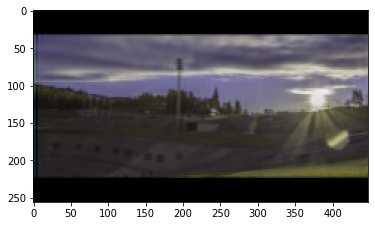

In [ ]:
import matplotlib.pyplot as plt
for x,y in data_loarder:
    plt.imshow(TF.to_pil_image(net(x.to(device))[0].cpu()))
    break


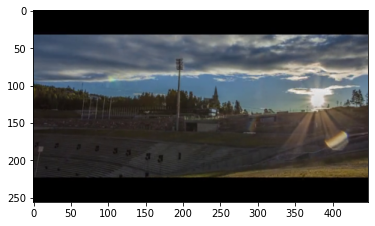

In [ ]:
plt.imshow(TF.to_pil_image(y[0]))

In [ ]:
import torch.optim as optim
from tqdm import tqdm
from pytorch_msssim import MS_SSIM

ms_ssim_module = MS_SSIM(data_range=255, size_average=True, channel=3)
optimizer = optim.Adamax(net.parameters(), lr=0.0025)
loss_function = nn.L1Loss()
learning_rates = []
training_loss = []
epochs = 10
alpha = 0.84
#learn = 1e-8
for epoch in tqdm(range(0,epochs)):
    for x,y in data_loarder:
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(x.to(device))
        loss = alpha * (1 - ms_ssim_module(output, y.to(device))) + (1 - alpha) * loss_function(output, y.to(device))
        loss.backward()
        optimizer.step()    # Does the update
        training_loss.append(loss.item())
        #learning_rates.append(learn)
        #learn += 0.001
        #for g in optimizer.param_groups:
            #g['lr'] += 0.001
    print("Epoch: {}  Loss: {}".format(epoch, loss))
    for g in optimizer.param_groups:
        g['lr'] *= 0.9



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [04:24<39:37, 264.15s/it]

Epoch: 0  Loss: 0.015409242361783981




 20%|██        | 2/10 [08:40<34:54, 261.77s/it]

Epoch: 1  Loss: 0.007067871280014515




 30%|███       | 3/10 [12:54<30:17, 259.60s/it]

Epoch: 2  Loss: 0.006438586860895157




 40%|████      | 4/10 [17:09<25:48, 258.01s/it]

Epoch: 3  Loss: 0.00822827871888876




 50%|█████     | 5/10 [21:24<21:26, 257.20s/it]

Epoch: 4  Loss: 0.007460354827344418




 60%|██████    | 6/10 [25:40<17:07, 256.77s/it]

Epoch: 5  Loss: 0.005458417348563671




 70%|███████   | 7/10 [29:55<12:48, 256.23s/it]

Epoch: 6  Loss: 0.006177847273647785




 80%|████████  | 8/10 [34:09<08:31, 255.78s/it]

Epoch: 7  Loss: 0.0044464003294706345




 90%|█████████ | 9/10 [38:24<04:15, 255.54s/it]

Epoch: 8  Loss: 0.0048760585486888885




100%|██████████| 10/10 [42:40<00:00, 256.06s/it]

Epoch: 9  Loss: 0.004462807904928923


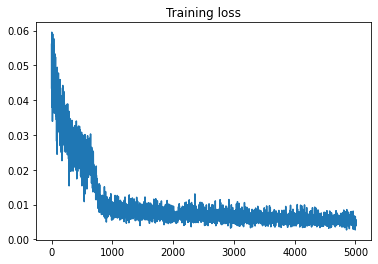

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.title("Training loss")
# plt.savefig("Training loss.png")
plt.show()
# wykres L za duzy learing rate

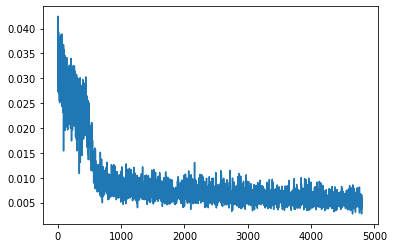

In [ ]:
plt.plot(training_loss[200:])
plt.show()

In [ ]:
round(torch.cuda.memory_allocated(0)/1024**3,1)

0.2

In [ ]:
round(torch.cuda.memory_cached(0)/1024**3,1)

2.1

ValueError: x and y must have same first dimension, but have shapes (0,) and (1213,)

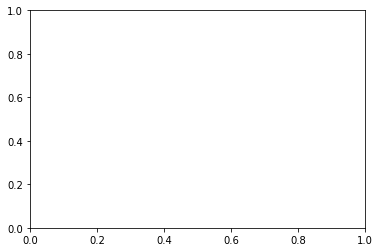

In [ ]:
plt.plot(learning_rates,training_loss)
plt.xscale("log")
plt.show()

In [ ]:
min(training_loss)

0.014193178154528141

In [ ]:
learning_rates[training_loss.index(min(training_loss))]

0.04400001000000003

In [ ]:
a = [training_loss[i] - training_loss[i-1] for i in range(1, len(training_loss))]
learning_rates[a.index(max(a))]

0.8130000100000007

In [ ]:
import os 
dir_path = os.path.dirname(os.path.realpath("ProjectY.ipynb"))

In [ ]:
dir_path

'C:\\PythonScripts'